In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing, model_selection
import string
from sklearn.feature_extraction.text import  CountVectorizer
from scipy.stats import boxcox
from scipy import sparse

/Users/jgzuke/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train_file = 'data/train.json'
test_file = 'data/test.json'
train = pd.read_json(train_file)
test = pd.read_json(test_file)

In [48]:
def get_manager_worth(manager_id):
    interests = train[train.manager_id == manager_id].interest_level.apply(lambda x: 2 - y_map[x])
    return sum(interests) / len(interests) if len(interests) > 0 else 0

manager_ids = np.concatenate((np.unique(train.manager_id), np.unique(test.manager_id)), axis=0)

manager_worths = {}
for manager_id in manager_ids:
    manager_worths[manager_id] = get_manager_worth(manager_id)

In [3]:
listing_id = test.listing_id.values

y_map = {'low': 2, 'medium': 1, 'high': 0}
train['interest_level'] = train['interest_level'].apply(lambda x: y_map[x])
y_train = train.interest_level.values

train = train.drop(['listing_id', 'interest_level'], axis=1)
test = test.drop('listing_id', axis=1)

ntrain = train.shape[0]

train_test = pd.concat((train, test), axis=0).reset_index(drop=True)

train_test['Date'] = pd.to_datetime(train_test['created'])
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day
train_test['Wday'] = train_test['Date'].dt.dayofweek
train_test['Yday'] = train_test['Date'].dt.dayofyear
train_test['hour'] = train_test['Date'].dt.hour

train_test = train_test.drop(['Date', 'created'], axis=1)

train_test['Zero_building_id'] = train_test['building_id'].apply(lambda x: 1 if x == '0' else 0)

train_test['desc'] = train_test['description']
train_test['desc'] = train_test['desc'].apply(lambda x: x.replace('<p><a  website_redacted ', ''))
train_test['desc'] = train_test['desc'].apply(lambda x: x.replace('!<br /><br />', ''))

string.punctuation.__add__('!!')
string.punctuation.__add__('(')
string.punctuation.__add__(')')

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

train_test['desc'] = train_test['desc'].apply(lambda x: x.translate(remove_punct_map))
train_test['desc_letters_count'] = train_test['description'].apply(lambda x: len(x.strip()))
train_test['desc_words_count'] = train_test['desc'].apply(lambda x: 0 if len(x.strip()) == 0 else len(x.split(' ')))

train_test.drop(['description', 'desc'], axis=1, inplace=True)

train_test['address1'] = train_test['display_address']
train_test['address1'] = train_test['address1'].apply(lambda x: x.lower())

address_map = {
    'w': 'west',
    'st.': 'street',
    'ave': 'avenue',
    'st': 'street',
    'e': 'east',
    'n': 'north',
    's': 'south'
}


def address_map_func(s):
    s = s.split(' ')
    out = []
    for x in s:
        if x in address_map:
            out.append(address_map[x])
        else:
            out.append(x)
    return ' '.join(out)


train_test['address1'] = train_test['address1'].apply(lambda x: x.translate(remove_punct_map))
train_test['address1'] = train_test['address1'].apply(lambda x: address_map_func(x))

new_cols = ['street', 'avenue', 'east', 'west', 'north', 'south']

for col in new_cols:
    train_test[col] = train_test['address1'].apply(lambda x: 1 if col in x else 0)

train_test['other_address'] = train_test[new_cols].apply(lambda x: 1 if x.sum() == 0 else 0, axis=1)

train_test['features_count'] = train_test['features'].apply(lambda x: len(x))
train_test['features2'] = train_test['features']
train_test['features2'] = train_test['features2'].apply(lambda x: ' '.join(x))

c_vect = CountVectorizer(stop_words='english', max_features=200, ngram_range=(1, 1))
c_vect.fit(train_test['features2'])

c_vect_sparse_1 = c_vect.transform(train_test['features2'])
c_vect_sparse1_cols = c_vect.get_feature_names()



train_test.drop(['features', 'features2'], axis=1, inplace=True)

train_test['manager_worths'] = train_test['manager_id'].apply(lambda x: manager_worths[x] if x in manager_worths else 0)

#managers_count = train_test['manager_id'].value_counts()

#train_test['top_10_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 90)] else 0)
#train_test['top_25_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 75)] else 0)
#train_test['top_5_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 95)] else 0)
#train_test['top_50_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 50)] else 0)
#train_test['top_1_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 99)] else 0)
#train_test['top_2_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 98)] else 0)
#train_test['top_15_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 85)] else 0)
#train_test['top_20_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 80)] else 0)
#train_test['top_30_manager'] = train_test['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
#    managers_count.values >= np.percentile(managers_count.values, 70)] else 0)

buildings_count = train_test['building_id'].value_counts()

train_test['top_10_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 90)] else 0)
train_test['top_25_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 75)] else 0)
train_test['top_5_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 95)] else 0)
train_test['top_50_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 50)] else 0)
train_test['top_1_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 99)] else 0)
train_test['top_2_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 98)] else 0)
train_test['top_15_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 85)] else 0)
train_test['top_20_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 80)] else 0)
train_test['top_30_building'] = train_test['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 70)] else 0)

train_test['photos_count'] = train_test['photos'].apply(lambda x: len(x))
train_test.drop(['photos', 'display_address', 'street_address'], axis=1, inplace=True)

categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']

for feat in categoricals:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_test[feat].values))
    train_test[feat] = lbl.transform(list(train_test[feat].values))

bc_price, tmp = boxcox(train_test.price)
train_test['bc_price'] = bc_price

train_test.drop('price', axis=1, inplace=True)
train_test['bathrooms_cat'] = train_test['bathrooms'].apply(lambda x: str(x))

train_test['bathrooms_cat'], labels = pd.factorize(train_test['bathrooms_cat'].values, sort=True)
train_test.drop('bathrooms', axis=1, inplace=True)

train_test['bedroom_cat'], labels = pd.factorize(train_test['bedrooms'].values, sort=True)
train_test.drop('bedrooms', axis=1, inplace=True)

features = list(train_test.columns)


train_test_cv1_sparse = sparse.hstack((train_test, c_vect_sparse_1)).tocsr()
#train_test_cv1_sparse = sparse.hstack((train_test)).tocsr()


x_train = train_test_cv1_sparse[:ntrain, :]
x_test = train_test_cv1_sparse[ntrain:, :]
features += c_vect_sparse1_cols

SEED = 777
NFOLDS = 5

params = {
    'eta':.01,
    'colsample_bytree':.8,
    'subsample':.8,
    'seed':0,
    'nthread':16,
    'objective':'multi:softprob',
    'eval_metric':'mlogloss',
    'num_class':3,
    'silent':1
}


dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test)

ValueError: cannot copy sequence with size 124011 to array axis with dimension 44

In [ ]:
bst = xgb.cv(params, dtrain, 10000, NFOLDS, early_stopping_rounds=50, verbose_eval=25)
best_rounds = np.argmin(bst['test-mlogloss-mean'])
bst = xgb.train(params, dtrain, best_rounds)

In [4]:
bst = xgb.cv(params, dtrain, 10000, NFOLDS, early_stopping_rounds=50, verbose_eval=25)
best_rounds = np.argmin(bst['test-mlogloss-mean'])

[0]	train-mlogloss:1.09232+2.37908e-05	test-mlogloss:1.09241+4.19733e-05
[25]	train-mlogloss:0.961509+0.000742988	test-mlogloss:0.96392+0.00104601
[50]	train-mlogloss:0.870132+0.00115059	test-mlogloss:0.874708+0.0016257
[75]	train-mlogloss:0.803892+0.00116569	test-mlogloss:0.810538+0.00225172
[100]	train-mlogloss:0.754486+0.00121665	test-mlogloss:0.763157+0.00282007
[125]	train-mlogloss:0.716823+0.00129038	test-mlogloss:0.727558+0.00335259
[150]	train-mlogloss:0.687709+0.00129095	test-mlogloss:0.700406+0.00386878
[175]	train-mlogloss:0.664784+0.0014248	test-mlogloss:0.679541+0.00420693
[200]	train-mlogloss:0.646375+0.0015535	test-mlogloss:0.663145+0.00443946
[225]	train-mlogloss:0.631351+0.00157149	test-mlogloss:0.650149+0.00470338
[250]	train-mlogloss:0.618784+0.00149985	test-mlogloss:0.639614+0.004965
[275]	train-mlogloss:0.608031+0.00139843	test-mlogloss:0.630912+0.00520895
[300]	train-mlogloss:0.598699+0.00129332	test-mlogloss:0.623642+0.00541186
[325]	train-mlogloss:0.590417+0.001

In [7]:
bst = xgb.train(params, dtrain, best_rounds)
preds = bst.predict(dtest)
preds = pd.DataFrame(preds)
cols = ['high', 'medium', 'low']
preds.columns = cols
preds['listing_id'] = listing_id
preds.to_csv('my_preds.csv', index=None)

In [9]:
%matplotlib inline

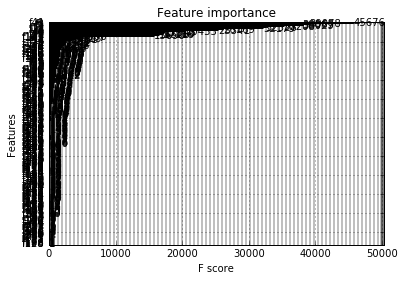

In [10]:
xgb.plot_importance(bst)

In [19]:
importance = sorted(importance.items(), key=lambda x: x[1])

In [34]:
len(importance)

234

In [33]:
len(features)

244